# Primerjava pristopov za specifične besede

V tej skripti primerjamo pristope za izbor specifičnih (ključnih) besed v besedilih.

In [1]:
import string
from collections import Counter
import random

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from textsemantics.server_api import ServerAPI
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display, Markdown

from utils import specific_words
from utils.word_enrichment import hypergeom_p_values, FDR

Naložimo metapodatke in dokumente za zadnjih 100 predlogov vladi in dokumente predprocesiramo.

In [2]:
nltk.download('stopwords', quiet=True)

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        # lematizer in rare cases produce empty strings - removing them
        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
metadata = api.get_metadata('CHC', sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
metadata["texts"] = texts
data = metadata[metadata["texts"].str.len() > 50]

tokens_list = preprocess(data["texts"])
print(f"Število dokumentov: {len(tokens_list)}")

Število dokumentov: 99


Pridobimo specifične besede z vsemi štirimi pristopi. Za vsak pristop dobimo seznam, ki vsebije po en seznam s specifičnimi besedami za vsak dokument.

In [3]:
specific_emb1 = specific_words.embedding_corpus_words(tokens_list)
specific_emb2 = specific_words.embedding_document_words(tokens_list)
specific_enrichment = specific_words.enrichment_words(tokens_list)
specific_tfidf = specific_words.tfidf_words(tokens_list)

print(f"Dolžina seznama s specifičnimi besedami - Vložitve korpus: {len(specific_emb1)}")
print(f"Dolžina seznama s specifičnimi besedami - Vložitve dokument: {len(specific_emb2)}")
print(f"Dolžina seznama s specifičnimi besedami - Obogatitev besed: {len(specific_enrichment)}")
print(f"Dolžina seznama s specifičnimi besedami - TF-IDF: {len(specific_tfidf)}")

Dolžina seznama s specifičnimi besedami - Vložitve korpus: 99
Dolžina seznama s specifičnimi besedami - Vložitve dokument: 99
Dolžina seznama s specifičnimi besedami - Obogatitev besed: 99
Dolžina seznama s specifičnimi besedami - TF-IDF: 99


Izpišimo še prvih 10 specifičnih besed, ki smo jih pridobili s pristopom **Z vložitvami na podlagi besed iz celotnega korpusa**.

In [4]:
pd.DataFrame(specific_emb1[0], columns=["Beseda", "Specifičnost"]).head(10)

,Beseda,Specifičnost
0,verski,-0.200020
1,denar,-0.175713
2,plačevati,-0.155468
3,cerkev,-0.154695
4,davek,-0.151973
5,pogreb,-0.150415
6,obred,-0.146842
7,premožen,-0.143223
8,blagajna,-0.141274
9,poroka,-0.140506


## Grafična primerjava specifičnih besed

Specifične besede, izbrane s štirimi različnimi pristopi, bomo najprej primerjali grafično s karto, ki primerja izbor specifičnih besed za posamezen dokument.

Pripravimo funkcijo, ki izpiše besedilo in specifične besede in izriše karto, ki prikazuje prisotnost posamezne besede pri vsaki od metod. Rezultate pokažemo na štirih besedilih.

In [5]:
def plot_specific_words(document_id):
    num_words = 15
    md = f"### {data.iloc[document_id].loc['title']}\n{data.iloc[document_id].loc['texts']}\n"

    method_names = ["Vložitve korpus", "Vložitve dokument", "Obogatitev besed", "TF-IDF"]
    sp_words = [specific_emb1, specific_emb2, specific_enrichment, specific_tfidf]
    spec_words = [[w for w, _ in method[document_id][:num_words]] for method in sp_words ]

    # join specific words for method
    for method, sp_words in zip(method_names, spec_words):
        md += f"- **{method}**: {', '.join(sp_words)}\n"
    display(Markdown(md))

    # heatmap
    all_words = [c for c, _ in Counter([y for x in spec_words for y in x]).most_common()]
    belongs = [[word in m for m in spec_words] for word in all_words]
    sns.heatmap(pd.DataFrame(belongs, columns=method_names, index=all_words), cmap='Blues')

### Videvanja z partnerjem z tujine med epidemijo.
Predlagam, da se kot izjema za prehajanje regije, občine ali državne meje, uvede tudi vzdrževanje stikov z partnerji iz tujine. Sam, kot tudi drugi smo namreč zaradi tega prizadeti, saj nas veliko živi ob meji s Hrvaško na primer, 15 min vožnje stran eden od drugega, a zaradi restriktivnih srečanje ni možno, čez Kolpo si pa lahko mahamo. Je bil 1. Val dovolj, da se nisem mogel videti s punco, katere tudi skoraj nisem prepoznal, po 2 mesecih razdvojenosti. Lp
- **Vložitve korpus**: meja, kolpa, regija, val, preža, migracija, tujina, vrana, povezava, vran, ina, punca, sosednji, okolica, stran
- **Vložitve dokument**: predlagati, lahek, velik, dovolj, sam, meja, videti, prepoznati, razdvojenost, prehajanje, punca, primer, tujina, kolpa, možen
- **Obogatitev besed**: vzdrževanje, punca, razdvojenost, partner, regija, mahati, mina, restriktiven, kolpa, živ, hrvaški, prehajanje, tujina, prepoznati, srečanje
- **TF-IDF**: meja, razdvojenost, punca, mahati, kolpa, restriktiven, mina, partner, vzdrževanje, regija, živ, prehajanje, hrvaški, tujina, prepoznati


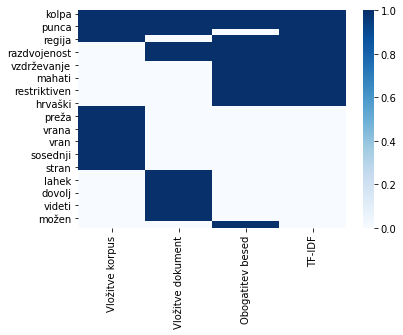

In [6]:
plot_specific_words(13)

Besede so razvrščene glede na število pristopov, ki je identificiralo besedo kot eno od 15 najbolj specifičnih.

### Letos učenci naj ne bodo ocenjeni
Zaradi ponovnega dela na daljavo bo znanje učencev slabo, hkrati bo pomanjkanje ocen oziroma bodo te verjetno (tako, kot lansko leto) bolj domišljijske, kot realne. Predlagam, da se za letošnje leto zgolj ugotovi, ali je učenec letnik OPRAVIL, OPRAVIL S POHVALO ali pa NI OPRAVIL. Za prehod na naslednji nivo šolanja (torej iz osnovne na srednjo ter srednje na visoko šolo) pa naj se končno ponovno uvede sprejemne izpite. Vsaka šola zase najbolje ve, katera znanja in sposobnosti želi pri svojih dijakih oziroma študentih. Prav tako je vsem jasno, da zbiranje točk za vpis s seštevanjem ocen, ki so ali niso realne/izsiljene/podarjene ni pošteno niti smiselno.
- **Vložitve korpus**: šolanje, dijak, izpit, srednji, učenec, znanje, srednješolec, učen, šolski, poučevanje, učitelj, študij, letošnji, ocenjevanje, učenje
- **Vložitve dokument**: predlagati, osnoven, šolanje, znanje, dijak, izpit, realen, smiseln, ponoven, šola, letošnji, vpis, slab, opravilo, končen
- **Obogatitev besed**: seštevanje, sposobnost, pohvala, opravilo, pomanjkanje, ocena, domišljijski, realneizsiljenepodarjen, vpis, ugotoviti, sprejemen, končen, letošnji, pošten, prehod
- **TF-IDF**: opravilo, ocena, znanje, učenec, srednji, ponoven, leto, šola, realneizsiljenepodarjen, seštevanje, sposobnost, pohvala, domišljijski, pomanjkanje, pošten


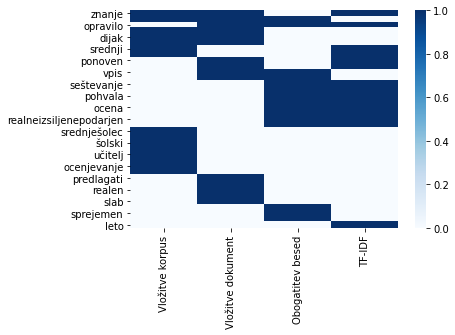

In [7]:
plot_specific_words(15)

### Finančna pomoč gorskim reševalcem 2
Ponovno dajem na glasovanje predlog v upanju, da bo sedaj zadosti podpore, da bi se ta predlog začel odvijat v pravo smer.
 
Predlagam, da bi ob posredovanjih gorske reševalne službe v primeru, da se pohodnik v hribih poškoduje in je bilo ob reševanju ugotovljeno, da ni imel ustrezne opreme za hojo v hribih denarno kaznuje pohodnika, kazen bi dodelil vodja reševanja in bi potem podal podatke za kazen naprej na policijo, in od te kazni bi se denar nameni gorski reševalni službi, ki je posredovala v tistem času, za primer recimo: reševanje brez helikopterja 100% gre denar v društvo, ob posredovanju z helikopterjem bi se ta kazen nekoliko razpolovila in bi nekaj denarja dobila enota HeNMP za stroške goriva nekaj pa gorska reševalna služba. Vemo, da je bil pred kakšnim letom na televiziji prispevek o gorski reševalni službi iz Kamnika kjer so zbirali sredstva za dostojen objekt v katerem bi imeli vso opremo za posredovanja in vozila. In menim, da bi s takim načinom lahko omogočili brezskrbno nadaljne posredovanje in ohranitev društev.
- **Vložitve korpus**: reševanje, posredovanje, gorski, služba, helikopter, posredovati, priskočiti, usposabljanje, reševati, kazen, policija, vozilo, usposabljati, kazenski, pohodnik
- **Vložitve dokument**: predlagati, imeti, posredovati, iti, omogočiti, kaznovati, lahek, vedeti, posredovanje, služba, podati, začeti, dobiti, policija, denar
- **Obogatitev besed**: kamnik, gorski, posredovanje, posredovati, dostojen, helikopter, henmp, glasovanje, podati, ugotovljen, reševalen, razpoloviti, poškodovati, pohodnik, brezskrben
- **TF-IDF**: reševalen, gorski, posredovanje, kazen, služba, reševanje, denar, helikopter, pohodnik, hrib, oprema, društvo, predlog, primer, ohranitev


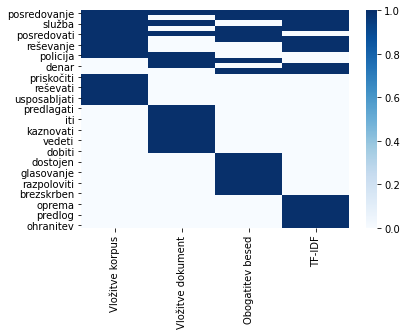

In [8]:
plot_specific_words(16)

## Primerjava pristopov za pridobivanje specifičnih besed

Zanima nas, katere metode najdejo podobne ključne besede. Metode analiziramo tako, da za vsako besedilo naključno izberemo nekaj besed. Te besede rangiramo glede na pomembnost med vsemi specifičnimi besedami pri vsaki od metod. Range primerjamo s Spearmanovo korelacijo rangov.

Najprej implementiramo funkcijo, ki izračuna range.

In [9]:
method_names = ["Vložitve korpus", "Vložitve dokument", "Obogatitev besed", "TF-IDF"]
methods_rankings = [specific_emb1, specific_emb2, specific_enrichment, specific_tfidf]
num_tokens = 10

def compute_ranks(words, idx):
    ranks = {}
    for name, ranking in zip(method_names, methods_rankings):
        specific_words = [w for w, _ in ranking[idx]]
        scores = [specific_words.index(word) for word in words]
        ranks[name] = np.argsort(scores)
    return ranks

def rank_correlation():
    correlations = np.zeros((len(method_names), len(method_names), len(tokens_list)))
    for i, tokens in enumerate(tokens_list): # for each document
        t_sample = random.sample(tokens, min(num_tokens, len(tokens)))
        ranks = compute_ranks(t_sample, i)
        for m1, method1 in enumerate(method_names):
            for m2, method2 in enumerate(method_names[m1:], start=m1):
                corr, _ = spearmanr(ranks[method1], ranks[method2])
                correlations[m1, m2, i] = corr
                correlations[m2, m1, i] = corr
    from functools import reduce
    return np.mean(correlations, axis=2)

correlations = pd.DataFrame(rank_correlation(), columns=method_names, index=method_names)

Tabelo koleracij izpišemo v obliki grafa. 

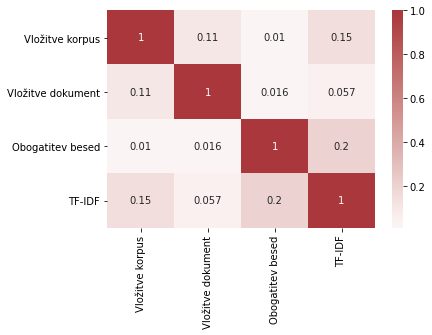

In [10]:
sns.heatmap(correlations, cmap="vlag", center=0, annot=True);